## Install Dependencies

In [ ]:
#for emoji detection
!pip install emot
!pip install emoji==1.7.0

# Topic Modelling
!pip install pyLDAvis
!pip install langdetect

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import TextBlob
import string
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
from pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import spacy

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

import seaborn as sns

import emoji
from emot.emo_unicode import UNICODE_EMOJI

import warnings
warnings.filterwarnings("ignore")

## Data Collection

In [ ]:
df = pd.read_csv('Suicide_Detection.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
df.notnull().sum()

text     232074
class    232074
dtype: int64

In [ ]:
df.groupby('class').count()

,text
class,
non-suicide,116037
suicide,116037


## Data Cleaning

Handling outliers

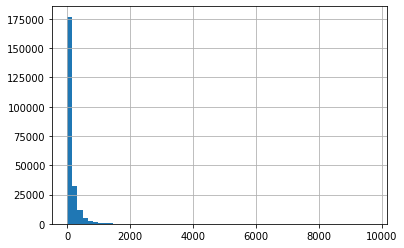

count    232074.000000
mean        131.925235
std         217.476787
min           1.000000
25%          26.000000
50%          60.000000
75%         155.000000
max        9684.000000
dtype: float64


In [ ]:
#Remove outlier rows by count of posts 
post_len = [len(x.split()) for x in df['text']]
pd.Series(post_len).hist(bins=60)
plt.show()
print(pd.Series(post_len).describe())

In [ ]:
long_text = df[df['text'].apply(lambda x: len(x.split()) > 155)]
long_text.groupby('class').count()

,text
class,
non-suicide,8637
suicide,49136


In [ ]:
#Remove rows with more then 75% num of text len =  155
cleaned_df = df[df['text'].apply(lambda x: len(x.split())<=155)]
cleaned_df.reset_index(drop=True, inplace=True)

In [ ]:
cleaned_df['class'].count()

174301

In [ ]:
cleaned_df['class'].value_counts()

non-suicide    107400
suicide         66901
Name: class, dtype: int64

Identifying texts in foreign languages

In [ ]:
# Language Detection - check if all texts are in English, else filter out
import langdetect 
from langdetect import DetectorFactory
DetectorFactory.seed = 0

def detect_lang(sentence):
  try:
    lang = langdetect.detect(sentence)
  except:
    lang = 'Other'
  return lang

cleaned_df['lang'] = cleaned_df['text'].apply(lambda x: detect_lang(x))

print(cleaned_df['lang'].value_counts())

cleaned_df = cleaned_df[cleaned_df['lang'] == 'en']
cleaned_df = cleaned_df.drop('lang', axis=1)

en       168826
da         1794
Other       468
af          379
so          303
no          269
nl          266
de          238
cy          212
fr          173
tl          158
it          146
et          114
id          112
ca          111
sv          102
es           61
pt           57
sq           55
hr           49
pl           46
sw           46
ro           42
hu           36
fi           33
uk           32
vi           30
sl           27
tr           24
sk           16
ja           14
ru           13
cs           10
bg            7
lt            6
ar            5
lv            4
el            3
he            3
zh-cn         3
ko            2
hi            2
mr            1
th            1
fa            1
bn            1
Name: lang, dtype: int64


Taking a subset of data

In [ ]:
split_cleaned_df = np.array_split(cleaned_df,  16)

# After trying to process all subsets, these subsets are able to process successfully with Google Colab limited resources
idx_chosen = [1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]
frames = []
for i in idx_chosen:
  frames.append(split_cleaned_df[i-1])

cleaned_subset = pd.concat(frames)
cleaned_subset.count()

## Text Pre-Processing

In [ ]:
# Removal of Punctuation & Special characters
def remove_punctuation(sentence):
    remove_chars = sentence.replace('\n',' ').replace('\r',' ')
    remove_digits = re.sub(r'\d+', '', remove_chars)
    return remove_digits.translate(str.maketrans('', '', string.punctuation))

# Handling Emoji in text and converting them to words that describes the emoji in words
def has_emoji(text):
    for char in text:
        if char in emoji.UNICODE_EMOJI['en']: 
            return True
    return False

# add space near emoji
def add_space(text):
    return ''.join(' ' + char + ' ' if char in UNICODE_EMOJI else char for char in text).strip()

def convert_emoji_to_words(text):
    with_space = add_space(text)
    return emoji.demojize(with_space, delimiters=("",""))

# Cut words with repeating chars
from textblob import Word
rx = re.compile(r'([^\W\d_])\1{2,}')

def cut_repeating_chars(sentence):
  return re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), sentence)

# Converting words to lowercase
def convert_lowercase(sentence):
  return sentence.lower()

# Spelling correction
def spell_correction(sentence):
  sentence = TextBlob(sentence)
  result = sentence.correct()
  return str(result)

# Tokenize
def tokenize(sentence):
  return sentence.split()

# Remove stop words 
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
  filtered_sentence = [w for w in tokens if not w.lower() in stop_words]
  return filtered_sentence

# Lemmatisation
def get_part_of_speech_tags(token):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    tag = nltk.pos_tag([token])[0][1][0].upper()
    
    return tag_dict.get(tag, wordnet.NOUN)
 
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(token):
  return lemmatizer.lemmatize(token, get_part_of_speech_tags(token))

def pre_process(sentence):
  sentence = remove_punctuation(sentence)
  
  if has_emoji(sentence):
    sentence = convert_emoji_to_words(sentence)
    
  sentence = cut_repeating_chars(sentence)
  sentence = convert_lowercase(sentence)
  sentence = spell_correction(sentence)
  tokens = tokenize(sentence)

  return tokens

In [ ]:
cleaned_subset['tokens'] = cleaned_subset['text'].apply(lambda x: pre_process(x))
cleaned_subset["tokens"] = cleaned_subset["tokens"].apply(lambda x: remove_stopwords(x))
# remove rows with null lists
cleaned_subset = cleaned_subset[cleaned_subset['tokens'].apply(lambda x: len(x) > 0)]
cleaned_subset["processed"] = cleaned_subset["tokens"].apply(lambda x: [lemmatize_tokens(token) for token in x])
cleaned_subset["processed_str"] = [' '.join(map(str,l)) for l in cleaned_subset['processed']]


In [ ]:
df_processed = cleaned_subset.drop("tokens", axis=1)
df_processed.head()

,text,class,processed,processed_str
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,"[ex, wife, threaten, suiciderecently, left, wi...",ex wife threaten suiciderecently left wife goo...
1,Am I weird I don't get affected by compliments...,non-suicide,"[weird, dont, get, affected, compliment, come,...",weird dont get affected compliment come someon...
2,Finally 2020 is almost over... So I can never ...,non-suicide,"[finally, almost, never, hear, bad, year, ever...",finally almost never hear bad year ever swear ...
3,i need helpjust help me im crying so hard,suicide,"[need, helpjust, help, cry, hard]",need helpjust help cry hard
4,It ends tonight.I can’t do it anymore. \nI quit.,suicide,"[end, tonight, can’t, anymore, quit]",end tonight can’t anymore quit


In [ ]:
df_processed.to_csv("../Data/Final Data.csv")